In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

continue_train = False

model_path = 'model.pt'
dataset_path = '../datasets/'

n_epochs = 10
batch_size = 32
learning_rate = 0.0005
momentum = 0.9
log_interval = 300

writer = SummaryWriter('logs')

random_seed = 1
torch.manual_seed(random_seed)

In [3]:
label_converter = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

In [4]:
transform = torchvision.transforms.Compose([ 
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.1307,),(0.3081,))
                ])

train_dataset = torchvision.datasets.EMNIST(
                    dataset_path,
                    split = 'balanced',
                    train = True,
                    download = True,
                    transform = transform)

test_dataset = torchvision.datasets.EMNIST(
                    dataset_path,
                    split = 'balanced',
                    train = False,
                    download = True,
                    transform = transform)

In [5]:
def get_data(train_dataset, test_dataset, batch_size):
    return (
        torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
        torch.utils.data.DataLoader(test_dataset, batch_size=batch_size*3, num_workers=4, pin_memory=True)
    )

In [6]:
train_ld, _ = get_data(train_dataset, test_dataset, batch_size)

dataiter = iter(train_ld)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


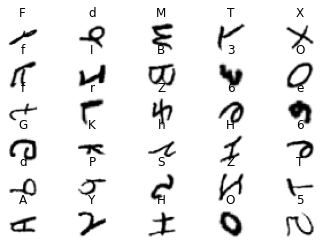

In [7]:
figure = plt.figure()
num_of_images = 30
for i in range(1, 31):
    plt.subplot(6, 5, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.title(label_converter[labels[i].item()])

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=5, padding='same'),
            nn.LeakyReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=None),
            nn.BatchNorm2d(50)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(50, 50, kernel_size=5, padding='same'),
            nn.LeakyReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=None),
            nn.BatchNorm2d(50)  
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=5, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(100*9, 200),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4)
        )
        self.linear2 = nn.Linear(200, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [9]:
summary(Net(), (64, 1, 28, 28), col_names=['input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds
Net                                      --                   --                   --                   --                   --
├─Sequential: 1-1                        [64, 1, 28, 28]      [64, 50, 14, 14]     --                   --                   --
│    └─Conv2d: 2-1                       [64, 1, 28, 28]      [64, 50, 28, 28]     1,300                [1, 50, 5, 5]        65,228,800
│    └─LeakyReLU: 2-2                    [64, 50, 28, 28]     [64, 50, 28, 28]     --                   --                   --
│    └─Dropout2d: 2-3                    [64, 50, 28, 28]     [64, 50, 28, 28]     --                   --                   --
│    └─MaxPool2d: 2-4                    [64, 50, 28, 28]     [64, 50, 14, 14]     --                   --                   --
│    └─BatchNorm2d: 2-5                  [64, 50, 14, 14]     [64, 50, 14, 14]     100   

In [10]:
def get_model():
    model = Net()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    if continue_train:
        network_state_dict = torch.load(model_path)
        model.load_state_dict(network_state_dict)
    
    return model, optimizer

def loss_batch(model, images, labels, opt=None):
    if opt is not None:
        loss = F.cross_entropy(model(images), labels)
        loss.backward()
        opt.step()
        opt.zero_grad()
    else:
        loss = F.cross_entropy(model(images), labels, reduction='sum')

    return loss.item()

def preprocess(data, labels):
    return data.view(-1, 1, 28, 28).to(device), labels.to(device)

class WrappedDataLoader:
    def __init__(self, data_loader, function):
        self.data_loader = data_loader
        self.function = function
        self.dataset = data_loader.dataset
    
    def __len__(self):
        return len(self.data_loader)
    
    def __iter__(self):
        batches = iter(self.data_loader)
        for batch in batches:
            yield (self.function(*batch))

In [11]:
def train(model, epochs, train_loader, test_loader, opt):
    scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.5)
    
    for epoch in range(1, epochs+1):        
        model.train()
        correct = 0
        for i, (images, labels) in enumerate(train_loader):
            preds = model(images)
            loss = loss_batch(model, images, labels, opt)
            pred = preds.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
            
            if i % log_interval == 0:
                progress_pct = round(100. * i / len(train_loader))
                print(f'Train Epoch: {epoch} ({progress_pct}%)\tLoss: {round(loss, 4)}')

        step = (i + 1) * epoch + (epoch-1) * len(train_loader)
        writer.add_scalar('Loss/train', loss, step)
        test_accuracy = 100. * correct / len(train_loader.dataset)
        test_accuracy = int(test_accuracy)
        writer.add_scalar('Accuracy/train', test_accuracy, epoch)
        
        test(epoch, model, test_loader)
        torch.save(model.state_dict(), model_path)
        if epoch is not epochs:
            scheduler.step()
    
    return model

In [12]:
def test(epoch, model, test_loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            preds = model(images)
            loss += loss_batch(model, images, labels)
            pred = preds.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
    
            step = (i+1) * epoch + (epoch-1) *len(test_loader)
        
        writer.add_scalar('Loss/test', loss / len(test_loader.dataset), step)
                
    loss /= len(test_loader.dataset)
        
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracy = int(test_accuracy)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    print(f'\nTest set: Avg. loss: {round(loss, 4)}, Accuracy: {correct}/{len(test_loader.dataset)} ({round(test_accuracy)}%)\n')

In [13]:
train_loader, test_loader = get_data(train_dataset, test_dataset, batch_size)
train_loader = WrappedDataLoader(train_loader, preprocess)
test_loader = WrappedDataLoader(test_loader, preprocess)
model, opt = get_model()

model = train(model, n_epochs, train_loader, test_loader, opt)

writer.add_graph(model, images.to(device))

Train Epoch: 1 (0%)	Loss: 3.8727
Train Epoch: 1 (9%)	Loss: 1.2018
Train Epoch: 1 (17%)	Loss: 0.6995
Train Epoch: 1 (26%)	Loss: 0.885
Train Epoch: 1 (34%)	Loss: 0.9555
Train Epoch: 1 (43%)	Loss: 0.7145
Train Epoch: 1 (51%)	Loss: 0.5549
Train Epoch: 1 (60%)	Loss: 0.8373
Train Epoch: 1 (68%)	Loss: 0.6703
Train Epoch: 1 (77%)	Loss: 0.5032
Train Epoch: 1 (85%)	Loss: 0.3022
Train Epoch: 1 (94%)	Loss: 0.2836

Test set: Avg. loss: 0.3734, Accuracy: 16299/18800 (86%)

Train Epoch: 2 (0%)	Loss: 0.3664
Train Epoch: 2 (9%)	Loss: 0.3643
Train Epoch: 2 (17%)	Loss: 0.2615
Train Epoch: 2 (26%)	Loss: 0.3391
Train Epoch: 2 (34%)	Loss: 0.2138
Train Epoch: 2 (43%)	Loss: 0.1918
Train Epoch: 2 (51%)	Loss: 0.3876
Train Epoch: 2 (60%)	Loss: 0.3608
Train Epoch: 2 (68%)	Loss: 0.2825
Train Epoch: 2 (77%)	Loss: 0.4142
Train Epoch: 2 (85%)	Loss: 0.1253
Train Epoch: 2 (94%)	Loss: 0.2186

Test set: Avg. loss: 0.3276, Accuracy: 16601/18800 (88%)

Train Epoch: 3 (0%)	Loss: 0.3567
Train Epoch: 3 (9%)	Loss: 0.7227
Train